In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
plt.style.use('dark_background')

In [10]:
df = pd.read_excel('../database/export_binance/df_new.xlsx')
df.head(3)

,Unnamed: 0,User_ID,UTC_Time,Account,Operation,Coin,Change,Remark
0,1,1,2021-05-31 09:00:00,Spot,Deposit,SOL,25.0,NaN
1,1,1,2021-05-31 09:00:00,Spot,Deposit,BTC,1.0,NaN
2,1,1,2021-05-31 09:00:00,Spot,Deposit,BNB,35.0,NaN


In [51]:
#total account balance per coin, enhanced with a current price in USDT
current_balance = df.groupby('Coin').sum()['Change']
df_current_prices = pd.read_excel('../database/prices/current_prices.xlsx', index_col=0)
holding_prices = []
for i in current_balance.index:
    if i == 'USDT':
        holding_prices.append(1)
    elif i == 'WETH':
        try:
            i == 'ETH'
            price = df_current_prices.loc[df_current_prices['symbol'] == (i + 'USDT')]['price'].values[0]
            holding_prices.append(price)
        except:
            holding_prices.append(np.nan)
    else:
        try:
            price = df_current_prices.loc[df_current_prices['symbol'] == (i + 'USDT')]['price'].values[0]
            holding_prices.append(price)
        except:
            holding_prices.append(np.nan)
current_balance = pd.DataFrame(current_balance)
current_balance['USDT_price'] = holding_prices
current_balance['USDT_value'] = holding_prices * current_balance['Change']
print(f'current total value: {round(current_balance["USDT_value"].sum(), 2)} USDT')
current_balance.sort_values(by='USDT_value', ascending=False, inplace=True)
current_balance = current_balance.loc[current_balance['USDT_value'] > 1]
current_balance.reset_index(inplace=True)
current_balance.head(5)

current total value: 84164.72 USDT


,Coin,Change,USDT_price,USDT_value
0,BTC,1.372650,30153.4700,41390.155469
1,BUSD,21403.548085,1.0007,21418.530568
2,USDT,5918.143314,1.0000,5918.143314
3,ETH,2.299233,1786.2500,4107.005589
4,BNB,9.546340,287.9000,2748.391243


In [50]:
overview_pivot = df.pivot_table(index='Coin', columns='Account', values='Change', aggfunc=np.sum)
overview_pivot.reset_index(inplace=True)
overview_pivot.head(5)

Account,Coin,Card,Spot,USDT-Futures
0,AAVE,NaN,1.100000,NaN
1,ADA,NaN,130.600000,NaN
2,ATOM,NaN,35.330308,NaN
3,AUDIO,NaN,200.000000,NaN
4,AVAX,NaN,59.720000,NaN


### account activity

In [8]:
account_activity = df.copy()
account_activity['UTC_Time'] = account_activity['UTC_Time'].apply(lambda x: x.strftime('%Y-%m'))
account_activity = account_activity.groupby('UTC_Time').count()
account_activity.reset_index(inplace=True)

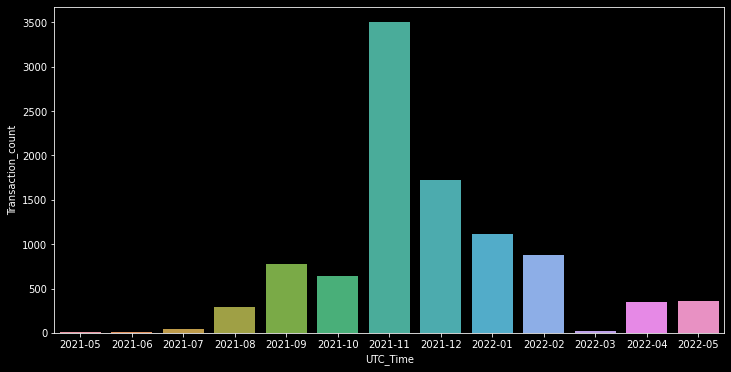

In [48]:
fig = plt.figure(figsize=(12, 6))
sns.barplot(x='UTC_Time', y='Change', data=account_activity)
plt.ylabel('Transaction_count');

### fees all accounts

In [53]:
#get monthly fees paid per coin
fees = df.loc[(df['Operation'] == 'Fee') | (df['Operation'] == 'Funding Fee') | (df['Operation'] == 'Referrer rebates')| (df['Operation'] == 'Commission Rebate')]
fees['year_month'] = fees['UTC_Time'].dt.strftime('%Y-%m')
fees_monthly_bal = fees.groupby(['year_month', 'Coin']).sum()['Change'].reset_index()
fees_monthly_bal = fees_monthly_bal.pivot(index='year_month', columns='Coin', values='Change').fillna(0)
#fees_monthly_bal = fees_monthly_bal.cumsum()
fees_monthly_bal

Coin,ATOM,BNB,BUSD,CAKE,ETH,FTT,USDT
year_month,,,,,,,
2021-07,0.000000,-0.016566,0.000000,0.00000,0.000000,0.00000,0.000000
2021-08,0.000000,-0.076776,0.000000,0.00000,0.000000,0.00000,0.000000
2021-09,0.000000,-0.259919,0.000000,0.00000,0.000000,0.00000,-23.299525
2021-10,0.000000,-0.075051,-321.545011,-0.31659,-0.007153,0.00000,-159.462408
2021-11,0.000000,-0.009576,0.000000,0.00000,0.000000,-0.01807,-2004.453118
2021-12,0.000000,-0.031099,0.000000,0.00000,0.000000,0.00000,758.142663
2022-01,0.000308,-0.009347,0.000000,0.00000,0.000000,0.00000,-225.921430
2022-02,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,-83.065229
2022-03,0.000000,-0.001676,0.000000,0.00000,0.000000,0.00000,0.000000


In [55]:
#import month-end prices for all coins in USDT
df_hist_prices = pd.read_excel('../database/prices/historical_prices.xlsx')
df_hist_prices.set_index('datetime', inplace=True)

end_dates = []
for i in fees_monthly_bal.index:
    if i.split('-')[1] == '02':
        end_dates.append(i + '-28')
    elif i.split('-')[1] == '01' or i.split('-')[1] == '03' or i.split('-')[1] == '05' or i.split('-')[1] == '07' or i.split('-')[1] == '08' or i.split('-')[1] == '10' or i.split('-')[1] == '12':
        end_dates.append(i + '-31')
    else:
        end_dates.append(i + '-30')
monthly_prices = df_hist_prices.loc[end_dates].reset_index()
monthly_prices['datetime'] = monthly_prices['datetime'].dt.strftime('%Y-%m')
monthly_prices.set_index('datetime', inplace=True)

#join prices and balances to get value in USDT
join = fees_monthly_bal.join(monthly_prices, how='outer')
for i in fees_monthly_bal.columns:
    if i == 'USDT':
        pass
    else:
        name_price = i + 'USDT'
        join[i] = join[i] * join[name_price]
join.drop(monthly_prices.columns, axis=1, inplace=True)
join['total_value'] = -join.sum(axis=1)
join['total_value_accum'] = join['total_value'].cumsum()
join

,ATOM,BNB,BUSD,CAKE,ETH,FTT,USDT,total_value,total_value_accum
year_month,,,,,,,,,
2021-07,0.000000,-5.506313,0.00000,0.000000,0.000000,0.000000,0.000000,5.506313,5.506313
2021-08,0.000000,-35.616544,0.00000,0.000000,0.000000,0.000000,0.000000,35.616544,41.122858
2021-09,0.000000,-100.718651,0.00000,0.000000,0.000000,0.000000,-23.299525,124.018176,165.141034
2021-10,0.000000,-39.371917,-321.31993,-5.587813,-30.667099,0.000000,-159.462408,556.409167,721.550201
2021-11,0.000000,-5.960867,0.00000,0.000000,0.000000,-0.915245,-2004.453118,2011.329230,2732.879431
2021-12,0.000000,-15.903942,0.00000,0.000000,0.000000,0.000000,758.142663,-742.238721,1990.640710
2022-01,0.008639,-3.498399,0.00000,0.000000,0.000000,0.000000,-225.921430,229.411190,2220.051899
2022-02,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,-83.065229,83.065229,2303.117128
2022-03,0.000000,-0.719004,0.00000,0.000000,0.000000,0.000000,0.000000,0.719004,2303.836132


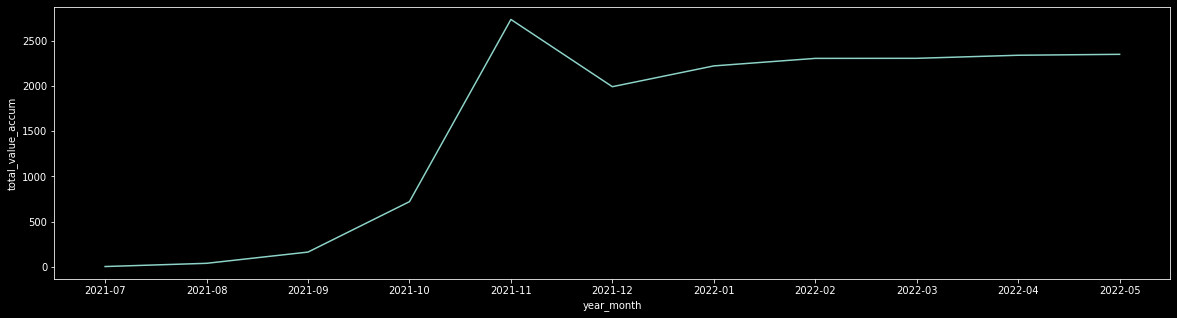

In [58]:
fig = plt.figure(figsize=(20, 5))
sns.lineplot(x='year_month', y='total_value_accum', data=join);

In [59]:
print(f'Total fees paid (to-date): {round(join.iloc[-1,-1], 2)} USDT')

Total fees paid (to-date): 2347.94 USDT
